<a href="https://colab.research.google.com/github/cbje18/P9/blob/main/Heston_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we implement the Heston semi-analytical formula for pricing European call options. We then use this pricing formula to calibrate the model to a dataset consisting of call options written on the SPY ETF, which tracks the S&P-500 index.

In [1]:
#Install dependencies first
!pip install eod
!pip install nelson_siegel_svensson
!pip install polygon-api-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 432.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
#Import needed libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import fsolve
from datetime import datetime as dt

from eod import EodHistoricalData
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [3]:
#First compute the characteristic function
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, tau, r):

    # constants
    a = kappa*theta
    b = kappa

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    return exp1*term2*exp2

In [4]:
#Define the integrand as a function
def integrand(phi, S0, v0, kappa, theta, sigma, rho, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

In [5]:
#Compute the price. We compute the Fourier integral using rectangular integration.
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width
    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

I now want to test this implementation. Firstly, I define the Black & Scholes formula for European call options, since I will use this to compute the implied volatility of an option. The B&S-formula is given by:


$$ C_{t}=S_{t}N(d_{1}) - e^{-r(T-t)}KN(d_{2}), 0\leq t \leq T, $$
$$ d_{1}=\frac{\ln(S_{t}/K) + (r+σ^2/2)(T-t)}{\sigma \sqrt{T-t}},$$
$$d_{2}= d_{1}-\sigma \sqrt{T-t}.$$


In [6]:
#Implementing the B&S-formula
def BS(S, K, ttm, vol):
  d1 = (np.log(S/K) + (r + (vol**2)/2)*ttm)/(vol*np.sqrt(ttm))
  d2 = d1 - vol*np.sqrt(ttm)
  return S*norm.cdf(d1) - np.exp(-r*ttm)*K*norm.cdf(d2)

We now create some test data to test the above formula. We will use 100 strike prices $K$ ranging from 60 to 140 and time to expirations $\tau=T-t$ will range from $0.01$ to $0.25$. I will set the interest rate $r=5\%$, which is close to Fed Funds Rate, which I guess is good enough. We assume that the current stock price is at 100, and volatility $σ=0.02$.

In [26]:
#Define parameters
strikes = np.linspace(start = 60, stop = 140, num = 100)
ttms = np.linspace(start = 0.01, stop = 0.25, num = 100)
r = 0.05
S = 100
vol = 0.02

#Compute the BS-prices and store them in a list
BS_prices = []
for i in range(0,100):
  BS_pr = BS(S, strikes[i], ttms[i], vol)
  BS_prices.append(BS_pr)


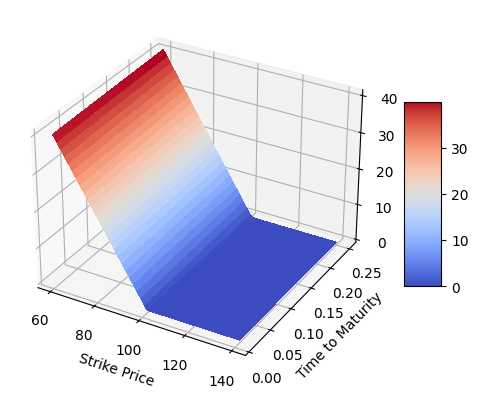

In [27]:
#Try to plot the surface with the prices as z-axis
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import plotly.graph_objects as go

# Creating plot
x = strikes
y = ttms
X,Y = np.meshgrid(x,y)
Z = BS(S, X,Y, vol)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel("Strike Price")
ax.set_ylabel("Time to Maturity")
ax.set_zlabel("Option Price")

plt.show()

The surface looks as expected. We now turn to implied volatility. If $\Pi_{t}$ denotes the market price of a call option with strike $K$ and time to maturity $\tau = T-t$, and $C^{BS}(\tau, K, \sigma)$ denotes the Black & Scholes calculated price of the same option, then the implied volatility $\sigma_{BS}>0$ of said option is given by

$$ \sigma_{BS}=\underset{\sigma}{\textrm{arg min}}\hspace{5 pt} \Pi_{t} - C^{BS}(\tau, K, \sigma) $$.

So finding the implied volatility is a matter of finding the root of $\Pi_{t}- C^{BS}$. I will firstly define the function as a function of the volatility $\sigma$, and then use fsolve for root findind.

In [ ]:
#Import the data set into Google Colaboratory. The data file is in GitHub.
from google.colab import files
uploaded = files.upload()

Saving option_data_spy.csv to option_data_spy.csv


In [ ]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['option_data_spy.csv']))

In [ ]:
df2

,Unnamed: 0,ContractID,ConractSize,Currency,Expiration,Strike,Last,Chg,ChgPct,Bid,Ask,Vol,OI,LastTradeTime,IV,ITM,TimeToExp,log_moneyness
0,1,SPY231107C00340000,REGULAR,USD,2023-11-07,340.0,95.10,0,0,0.0,0.00,7.0,7,2023-11-06 14:54:20,0.000010,True,0.000000,0.247985
1,2,SPY231107C00359000,REGULAR,USD,2023-11-07,359.0,51.83,0,0,0.0,0.00,1.0,1,2023-10-27 15:12:18,0.000010,True,0.000000,0.193609
2,3,SPY231107C00362000,REGULAR,USD,2023-11-07,362.0,58.66,0,0,0.0,0.00,1.0,1,2023-11-01 10:19:57,0.000010,True,0.000000,0.185287
3,4,SPY231107C00378000,REGULAR,USD,2023-11-07,378.0,36.40,0,0,0.0,0.00,2.0,2,2023-10-30 09:31:11,0.000010,True,0.000000,0.142037
4,5,SPY231107C00379000,REGULAR,USD,2023-11-07,379.0,32.07,0,0,0.0,0.00,2.0,1,2023-10-27 13:57:48,0.000010,True,0.000000,0.139395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,2765,SPY250321C00645000,REGULAR,USD,2025-03-21,645.0,0.51,0,0,0.0,0.83,1.0,2,2023-09-29 11:02:57,0.165841,False,1.368925,-0.392319
2765,2766,SPY250321C00650000,REGULAR,USD,2025-03-21,650.0,0.40,0,0,0.0,0.00,1.0,2,2023-10-19 09:30:31,0.062509,False,1.368925,-0.400041
2766,2767,SPY250321C00670000,REGULAR,USD,2025-03-21,670.0,0.25,0,0,0.0,0.00,11.0,21,2023-10-19 14:17:59,0.062509,False,1.368925,-0.430347
2767,2768,SPY250321C00675000,REGULAR,USD,2025-03-21,675.0,0.20,0,0,0.0,0.00,2.0,143,2023-11-03 11:50:24,0.062509,False,1.368925,-0.437782


In [ ]:
P = df2['Last']
S0 = 434.77
K = df2['Strike']
r = 0.05 #interest rate - set to Feds Funds rate?!?
tau = df2["TimeToExp"]

In [ ]:
heston_price_rec(S0, 340, v0, kappa, theta, sigma, rho, 0, r)

NameError: ignored

In [ ]:
#This is the calibration of the Heston Model. Takes forever to run, so I have just written the result of the calibration in the subsequent block.
params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.2]},
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,0]},
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]
def SqErr(x):
    v0, kappa, theta, sigma, rho = [param for param in x]

    # Decided to use rectangular integration function in the end
    err = np.sum( (P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, tau, r))**2 )

    # Zero penalty term - no good guesses for parameters
    pen = 0 #np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

    return err + pen
result = minimize(SqErr, x0, tol = 1e-3, method='L-BFGS-B', options={'maxiter': 1e4 }, bounds=bnds)
v0, kappa, theta, sigma, rho = [param for param in result.x]
v0, kappa, theta, sigma, rho

print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 276178.86114028073
        x: [ 1.851e-02  4.986e+00  2.119e-02  9.930e-01  0.000e+00]
      nit: 9
      jac: [-4.926e+03 -8.155e+02 -6.003e+03  5.800e+03 -3.038e+04]
     nfev: 72
     njev: 12
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [ ]:
v0 = 0.08556582149362034
kappa = 3.2915995657854475
theta = 0.04285581063825
sigma = 0.40205984
rho = -0.82915995657

In [ ]:
#Now want to price 100 randomly chosen options from the data set
import random
indices = list(range(0,2769))

option_indices = random.sample(indices,100)
print(option_indices)

[1461, 348, 1052, 1171, 1432, 1189, 167, 1550, 490, 906, 2528, 748, 2529, 1100, 1966, 2038, 2695, 169, 305, 507, 2138, 2158, 1182, 1239, 2283, 17, 1876, 1055, 1842, 555, 2398, 534, 876, 1693, 780, 2316, 2679, 1380, 1353, 647, 1399, 46, 700, 2345, 270, 1175, 671, 1283, 1067, 837, 2054, 1287, 210, 1834, 918, 373, 2752, 36, 2493, 2346, 933, 1328, 2688, 1864, 294, 1025, 96, 1723, 1754, 1161, 2435, 2284, 2142, 139, 52, 2440, 2367, 2192, 2538, 2464, 1005, 2200, 1856, 1817, 1360, 2468, 1476, 1280, 2017, 657, 1260, 2262, 2187, 1206, 1632, 1560, 574, 721, 760, 2424]


In [ ]:
heston_prices = []
for i in option_indices:
  price = heston_price_rec(S0, df2["Strike"][i], v0, kappa, theta, sigma, rho, df2["TimeToExp"][i], r)
  heston_prices.append(price)

In [ ]:
print(heston_prices[16])
print(option_indices[16])
df2["Last"][2357]

31.280871687895612
2737


0.13

In [ ]:
df2["Last"][option_indices]

2409    38.74
782      0.80
261     15.74
601     47.72
1775    62.72
        ...  
2327     3.25
1696    22.49
325      0.01
1353    58.10
1064    62.97
Name: Last, Length: 100, dtype: float64

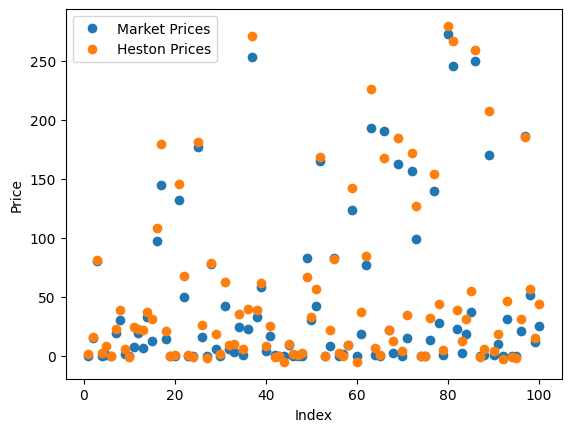

In [ ]:
index = list(range(1,101))
plt.plot(index, df2["Last"][option_indices], "o", label = "Market Prices")
plt.plot(index, heston_prices, "o", label = "Heston Prices")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

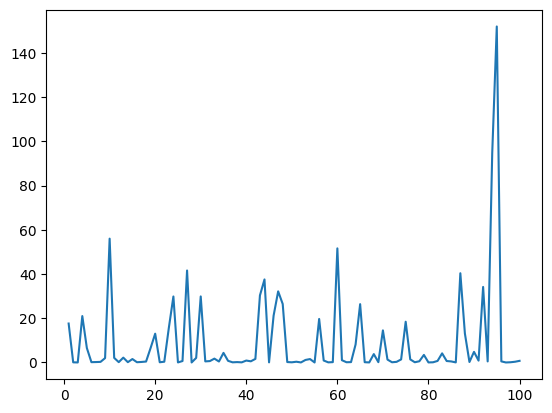

In [ ]:
error = np.abs((df2["Last"][option_indices] - heston_prices)/df2["Last"][option_indices])
plt.plot(index, error)

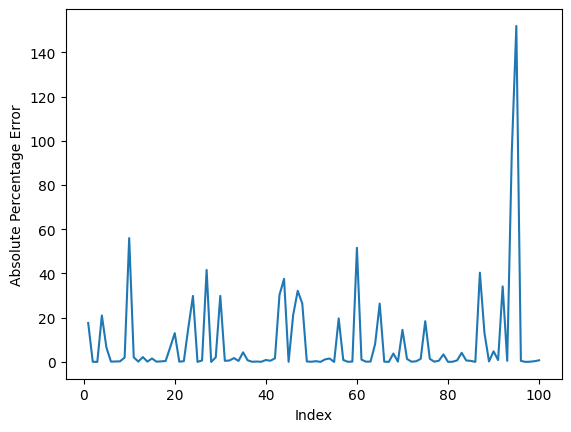

In [ ]:
error = np.abs((np.array(df2["Last"][option_indices]) - np.array(heston_prices))/np.array(df2["Last"][option_indices]))
plt.plot(index, error)
plt.xlabel("Index")
plt.ylabel("Absolute Percentage Error")
plt.show()

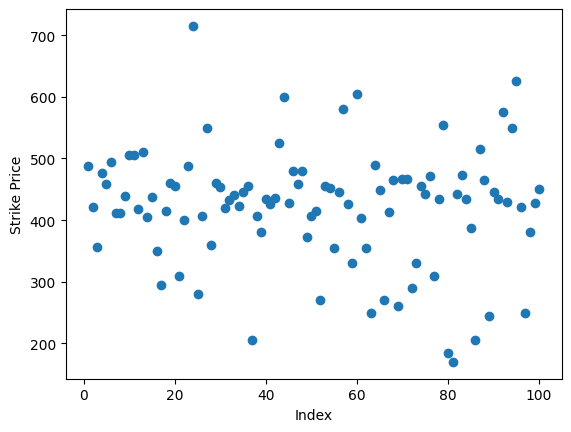

In [ ]:
plt.plot(index, df2["Strike"][option_indices], "o")
plt.xlabel("Index")
plt.ylabel("Strike Price")
plt.show()

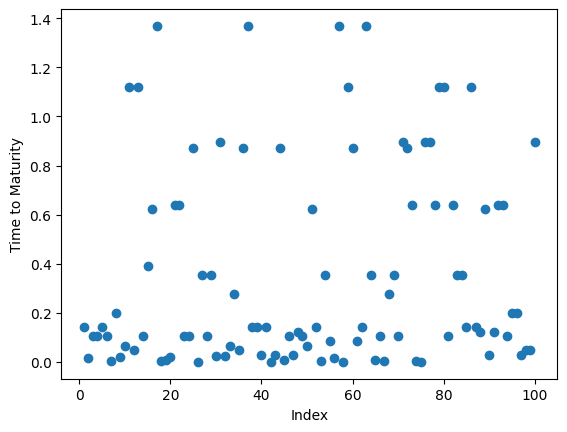

In [ ]:
plt.plot(index, df2["TimeToExp"][option_indices], "o")
plt.xlabel("Index")
plt.ylabel("Time to Maturity")
plt.show()

In [ ]:
sub_data = df2[df2['ITM'] == False]
#sub_data = sub_data[sub_data["Expiration"] == "2023-11-10"]
sub_data

,Unnamed: 0,ContractID,ConractSize,Currency,Expiration,Strike,Last,Chg,ChgPct,Bid,Ask,Vol,OI,LastTradeTime,IV,ITM,TimeToExp,log_moneyness
46,47,SPY231107C00436000,REGULAR,USD,2023-11-07,436.0,0.82,0,0,0.0,0.00,127296.0,16875,2023-11-06 16:14:58,0.003916,False,0.000000,-0.000711
47,48,SPY231107C00437000,REGULAR,USD,2023-11-07,437.0,0.46,0,0,0.0,0.00,60937.0,10674,2023-11-06 16:14:56,0.015635,False,0.000000,-0.003002
48,49,SPY231107C00438000,REGULAR,USD,2023-11-07,438.0,0.23,0,0,0.0,0.00,49005.0,16762,2023-11-06 16:14:58,0.031260,False,0.000000,-0.005288
49,50,SPY231107C00439000,REGULAR,USD,2023-11-07,439.0,0.10,0,0,0.0,0.00,42902.0,22248,2023-11-06 16:14:57,0.031260,False,0.000000,-0.007568
50,51,SPY231107C00440000,REGULAR,USD,2023-11-07,440.0,0.05,0,0,0.0,0.00,24796.0,11818,2023-11-06 16:14:45,0.062509,False,0.000000,-0.009844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,2765,SPY250321C00645000,REGULAR,USD,2025-03-21,645.0,0.51,0,0,0.0,0.83,1.0,2,2023-09-29 11:02:57,0.165841,False,1.368925,-0.392319
2765,2766,SPY250321C00650000,REGULAR,USD,2025-03-21,650.0,0.40,0,0,0.0,0.00,1.0,2,2023-10-19 09:30:31,0.062509,False,1.368925,-0.400041
2766,2767,SPY250321C00670000,REGULAR,USD,2025-03-21,670.0,0.25,0,0,0.0,0.00,11.0,21,2023-10-19 14:17:59,0.062509,False,1.368925,-0.430347
2767,2768,SPY250321C00675000,REGULAR,USD,2025-03-21,675.0,0.20,0,0,0.0,0.00,2.0,143,2023-11-03 11:50:24,0.062509,False,1.368925,-0.437782


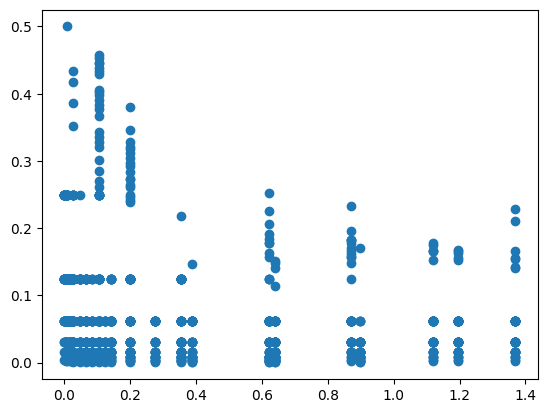

In [ ]:
plt.plot(sub_data['TimeToExp'], sub_data['IV'], "o")

In [ ]:
def BSM(S, K, vol, ttm):
  d1 = ((np.log(S/K) + (vol**2)/2)*ttm)/(vol*np.sqrt(ttm))
  d2 = d1 - vol*np.sqrt(ttm)
  price = norm.cdf(d1)*S - K*norm.cdf(d2)
  return price

def impVol(price, S, K, ttm):
  def f(vol):
    res = price - BSM(S,K,vol,ttm)
    return res
  imp_vol = fsolve(f, [0,5])
  imp_vol = imp_vol
  return imp_vol

In [ ]:
heston_price_rec(S0, 435, v0, kappa, theta, sigma, rho, 0.013689, r)

5.935686847331883

In [ ]:
impVol(135.5381, S0, 300, 0.013689)[0]

3.9768748221264607

In [ ]:
heston_implied_vols = []

for i in sub_data.index:
  heston_prices = heston_price_rec(S0, sub_data['Strike'][i], v0, kappa, theta, sigma, rho, sub_data['TimeToExp'][i], r = 0.05)
  imp_vol = impVol(heston_prices, S0, sub_data['Strike'][i], sub_data['TimeToExp'][i])
  heston_implied_vols.append(imp_vol[0])

<ipython-input-27-55bc357cd69f>:2: RuntimeWarning: invalid value encountered in divide
  d1 = ((np.log(S/K) + (vol**2)/2)*ttm)/(vol*np.sqrt(ttm))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


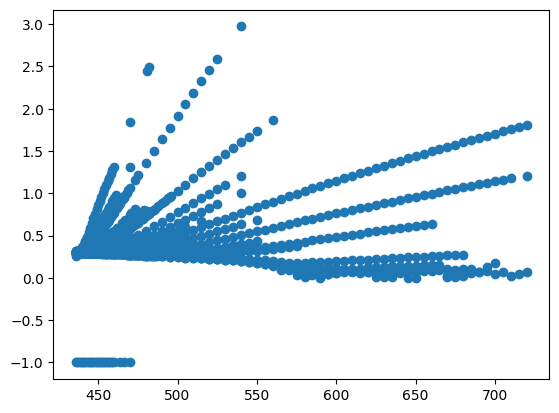

In [ ]:
plt.plot(sub_data['Strike'], heston_implied_vols, "o")

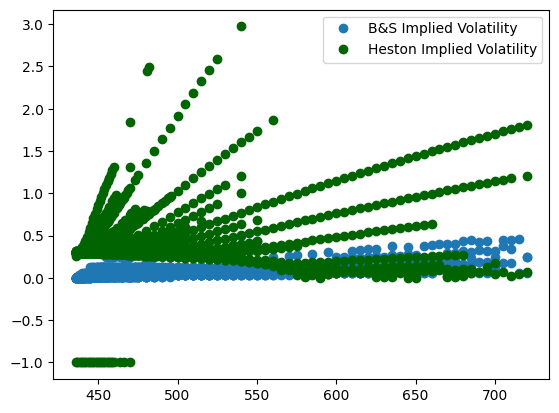

In [ ]:
plt.plot(sub_data['Strike'], sub_data['IV'], "o", label = "B&S Implied Volatility")
plt.plot(sub_data['Strike'], heston_implied_vols, "o", color = "darkgreen", label = "Heston Implied Volatility")
plt.legend()
plt.show()

<ipython-input-43-329a9dd342ad>:2: RuntimeWarning: divide by zero encountered in power
  return 0.4*x**(0.13-0.5)


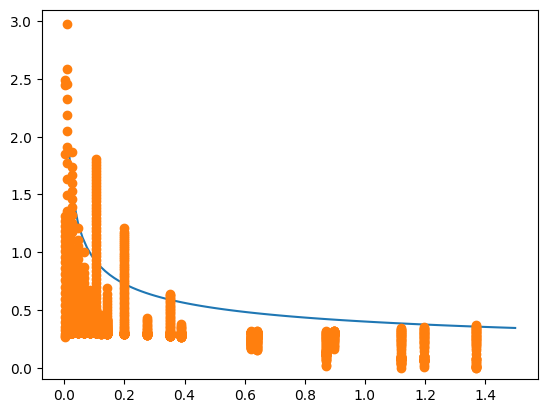

In [ ]:
def g(x):
  return 0.4*x**(0.13-0.5)

x_vals = np.linspace(0, 1.5, 100)

plt.plot(x_vals, g(x_vals))
plt.plot(sub_data['TimeToExp'], heston_implied_vols, "o")
plt.ylim(-0.1,3.1)
plt.show()